In [9]:
import ipython_memory_usage as imu
imu.start_watching_memory()
imu.stop_watching_memory()
from memory_profiler import memory_usage

In [33]:
from IPython.parallel import Client, interactive
c = Client(profile='parallel_python2.7')
dview = c.direct_view()
lview = c.load_balanced_view()
print len(dview)
with dview.sync_imports():
    import numpy
    from mitgcmdata import MITgcmmodel, layers, budgets
    from jmd95 import eos

IOError: [Errno 2] No such file or directory: u'/home/rpa/.ipython/profile_parallel_python2.7/security/ipcontroller-client.json'

In [37]:
import numpy
from mitgcmdata import MITgcmmodel, layers, budgets
from jmd95 import eos
from matplotlib import pyplot as plt
np = numpy
reload(layers)
reload(budgets)

%matplotlib inline
plt.rcParams['image.origin'] = 'bottom'

In [3]:
# the controlled run
ddir = '/data/scratch/rpa/SOSE/run_matt'
#ddir = '/glade/scratch/rpa/SOSE/run_matt_layers'
N = 438

iter0 = 480
diters= 480
deltaTclock = 900
iters = range(iter0, iter0+diters*N, diters)

layers_name = '1RHO'

m = MITgcmmodel.ModelInstance(output_dir=ddir, default_iter= iters[-1])

extra_mask = np.zeros(m.shape)
extra_mask[:,-1] = 1

Slevs = np.linspace(32,38,200)

drho1 = 0.002
drho2 = 0.025

rho0 = 1027.9

drho = np.hstack([
        drho1 * np.ones(100),
        np.linspace(drho1, drho2, 200),
        drho2 * np.ones(100),
])
rholevs = (rho0 - np.cumsum(drho))[::-1]

/data/scratch/rpa/SOSE/run_matt/XC.meta
/data/scratch/rpa/SOSE/run_matt/XG.meta
/data/scratch/rpa/SOSE/run_matt/YC.meta
/data/scratch/rpa/SOSE/run_matt/YG.meta
/data/scratch/rpa/SOSE/run_matt/DYC.meta
/data/scratch/rpa/SOSE/run_matt/DYG.meta
/data/scratch/rpa/SOSE/run_matt/DXC.meta
/data/scratch/rpa/SOSE/run_matt/DXG.meta
/data/scratch/rpa/SOSE/run_matt/RAC.meta
/data/scratch/rpa/SOSE/run_matt/RC.meta
/data/scratch/rpa/SOSE/run_matt/RF.meta
/data/scratch/rpa/SOSE/run_matt/DRC.meta
/data/scratch/rpa/SOSE/run_matt/DRF.meta
/data/scratch/rpa/SOSE/run_matt/Depth.meta
/data/scratch/rpa/SOSE/run_matt/hFacC.meta
/data/scratch/rpa/SOSE/run_matt/hFacS.meta
/data/scratch/rpa/SOSE/run_matt/hFacW.meta
/home/rpa/mitgcmdata/mitgcmdata/MITgcmmodel.py:75: RuntimeWarning: divide by zero encountered in reciprocal
  (self.rac * self.drf * self.hFacC)**-1, 0.)


2160 320  42
In [3] used 1144.1719 MiB RAM in 1.69s, peaked 50.64 MiB above current, total RAM usage 1208.43 MiB


In [4]:
# scatter variables to engines
dview.push(dict(m=m, extra_mask=extra_mask, Slevs=Slevs, rholevs=rholevs))

<AsyncResult: _push>

In [38]:
#@interactive
def calc_transformation(i):
    theta = m.rdmds('SOstt_5d', i, rec=0)
    salt = m.rdmds('SOstt_5d', i, rec=1)
    print theta.shape
    print salt.shape
    #rho, drhodt, drhods = eos.state_surface(theta.ravel(), salt.ravel())
    rho, drhodt, drhods = eos.state_surface(theta.ravel(), salt.ravel())
    rho.shape = theta.shape
    drhods.shape = theta.shape
    drhodt.shape = theta.shape
    
    salt_budget = budgets.TracerBudget(m,
                    'SO_Sbdg5', 'SO_Surf5d', trname='SLT',
                    iters=i)
    wmb_sig0 = budgets.WaterMassBudget(m, rholevs,
                            extra_mask=extra_mask)
    #trs, labels = wmb_salt.calc_transformation_rates(salt, salt_budget)
    trrho, labels = wmb_sig0.calc_transformation_rates(rho, salt_budget, scalefac=drhods)

    return trrho, labels

In [39]:
wmt_rho_test, labels = calc_transformation(iters[0])

/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000000480.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000000480.meta
/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000000480.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000000480.meta


(42, 320, 2160)
(42, 320, 2160)


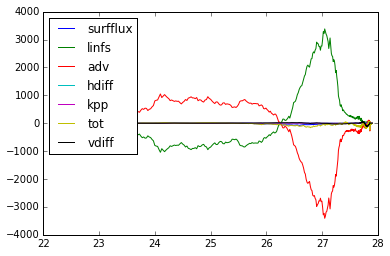

In [41]:
plt.plot(rholevs[1:]-1000., wmt_rho_test.T/1e6)
plt.legend(labels, loc='upper left')

In [42]:
wmt_rho = map(calc_transformation, iters)

/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000000480.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000000480.meta
/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000000480.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000000480.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000000960.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000000960.meta


(42, 320, 2160)
(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000000960.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000000960.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000001440.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000001440.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000001440.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000001440.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000001920.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000001920.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000001920.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000001920.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000002400.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000002400.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000002400.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000002400.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000002880.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000002880.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000002880.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000002880.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000003360.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000003360.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000003360.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000003360.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000003840.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000003840.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000003840.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000003840.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000004320.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000004320.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000004320.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000004320.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000004800.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000004800.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000004800.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000004800.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000005280.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000005280.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000005280.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000005280.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000005760.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000005760.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000005760.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000005760.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000006240.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000006240.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000006240.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000006240.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000006720.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000006720.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000006720.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000006720.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000007200.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000007200.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000007200.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000007200.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000007680.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000007680.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000007680.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000007680.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000008160.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000008160.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000008160.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000008160.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000008640.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000008640.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000008640.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000008640.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000009120.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000009120.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000009120.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000009120.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000009600.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000009600.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000009600.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000009600.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000010080.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000010080.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000010080.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000010080.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000010560.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000010560.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000010560.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000010560.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000011040.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000011040.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000011040.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000011040.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000011520.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000011520.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000011520.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000011520.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000012000.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000012000.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000012000.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000012000.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000012480.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000012480.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000012480.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000012480.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000012960.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000012960.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000012960.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000012960.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000013440.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000013440.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000013440.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000013440.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000013920.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000013920.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000013920.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000013920.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000014400.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000014400.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000014400.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000014400.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000014880.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000014880.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000014880.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000014880.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000015360.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000015360.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000015360.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000015360.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000015840.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000015840.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000015840.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000015840.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000016320.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000016320.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000016320.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000016320.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000016800.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000016800.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000016800.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000016800.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000017280.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000017280.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000017280.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000017280.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000017760.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000017760.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000017760.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000017760.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000018240.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000018240.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000018240.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000018240.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000018720.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000018720.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000018720.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000018720.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000019200.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000019200.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000019200.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000019200.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000019680.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000019680.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000019680.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000019680.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000020160.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000020160.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000020160.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000020160.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000020640.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000020640.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000020640.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000020640.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000021120.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000021120.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000021120.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000021120.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000021600.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000021600.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000021600.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000021600.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000022080.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000022080.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000022080.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000022080.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000022560.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000022560.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000022560.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000022560.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000023040.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000023040.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000023040.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000023040.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000023520.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000023520.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000023520.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000023520.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000024000.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000024000.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000024000.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000024000.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000024480.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000024480.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000024480.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000024480.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000024960.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000024960.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000024960.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000024960.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000025440.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000025440.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000025440.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000025440.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000025920.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000025920.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000025920.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000025920.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000026400.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000026400.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000026400.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000026400.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000026880.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000026880.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000026880.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000026880.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000027360.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000027360.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000027360.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000027360.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000027840.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000027840.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000027840.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000027840.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000028320.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000028320.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000028320.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000028320.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000028800.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000028800.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000028800.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000028800.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000029280.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000029280.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000029280.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000029280.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000029760.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000029760.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000029760.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000029760.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000030240.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000030240.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000030240.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000030240.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000030720.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000030720.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000030720.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000030720.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000031200.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000031200.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000031200.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000031200.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000031680.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000031680.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000031680.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000031680.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000032160.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000032160.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000032160.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000032160.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000032640.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000032640.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000032640.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000032640.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000033120.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000033120.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000033120.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000033120.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000033600.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000033600.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000033600.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000033600.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000034080.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000034080.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000034080.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000034080.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000034560.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000034560.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000034560.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000034560.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000035040.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000035040.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000035040.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000035040.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000035520.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000035520.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000035520.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000035520.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000036000.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000036000.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000036000.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000036000.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000036480.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000036480.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000036480.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000036480.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000036960.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000036960.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000036960.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000036960.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000037440.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000037440.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000037440.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000037440.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000037920.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000037920.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000037920.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000037920.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000038400.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000038400.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000038400.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000038400.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000038880.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000038880.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000038880.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000038880.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000039360.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000039360.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000039360.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000039360.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000039840.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000039840.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000039840.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000039840.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000040320.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000040320.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000040320.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000040320.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000040800.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000040800.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000040800.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000040800.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000041280.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000041280.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000041280.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000041280.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000041760.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000041760.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000041760.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000041760.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000042240.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000042240.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000042240.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000042240.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000042720.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000042720.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000042720.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000042720.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000043200.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000043200.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000043200.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000043200.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000043680.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000043680.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000043680.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000043680.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000044160.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000044160.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000044160.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000044160.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000044640.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000044640.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000044640.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000044640.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000045120.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000045120.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000045120.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000045120.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000045600.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000045600.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000045600.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000045600.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000046080.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000046080.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000046080.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000046080.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000046560.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000046560.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000046560.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000046560.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000047040.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000047040.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000047040.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000047040.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000047520.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000047520.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000047520.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000047520.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000048000.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000048000.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000048000.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000048000.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000048480.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000048480.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000048480.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000048480.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000048960.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000048960.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000048960.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000048960.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000049440.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000049440.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000049440.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000049440.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000049920.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000049920.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000049920.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000049920.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000050400.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000050400.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000050400.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000050400.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000050880.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000050880.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000050880.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000050880.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000051360.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000051360.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000051360.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000051360.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000051840.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000051840.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000051840.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000051840.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000052320.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000052320.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000052320.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000052320.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000052800.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000052800.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000052800.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000052800.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000053280.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000053280.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000053280.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000053280.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000053760.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000053760.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000053760.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000053760.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000054240.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000054240.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000054240.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000054240.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000054720.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000054720.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000054720.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000054720.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000055200.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000055200.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000055200.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000055200.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000055680.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000055680.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000055680.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000055680.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000056160.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000056160.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000056160.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000056160.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000056640.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000056640.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000056640.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000056640.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000057120.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000057120.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000057120.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000057120.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000057600.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000057600.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000057600.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000057600.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000058080.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000058080.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000058080.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000058080.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000058560.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000058560.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000058560.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000058560.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000059040.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000059040.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000059040.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000059040.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000059520.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000059520.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000059520.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000059520.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000060000.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000060000.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000060000.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000060000.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000060480.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000060480.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000060480.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000060480.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000060960.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000060960.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000060960.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000060960.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000061440.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000061440.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000061440.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000061440.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000061920.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000061920.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000061920.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000061920.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000062400.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000062400.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000062400.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000062400.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000062880.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000062880.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000062880.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000062880.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000063360.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000063360.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000063360.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000063360.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000063840.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000063840.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000063840.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000063840.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000064320.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000064320.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000064320.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000064320.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000064800.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000064800.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000064800.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000064800.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000065280.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000065280.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000065280.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000065280.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000065760.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000065760.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000065760.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000065760.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000066240.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000066240.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000066240.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000066240.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000066720.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000066720.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000066720.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000066720.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000067200.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000067200.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000067200.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000067200.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000067680.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000067680.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000067680.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000067680.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000068160.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000068160.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000068160.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000068160.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000068640.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000068640.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000068640.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000068640.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000069120.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000069120.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000069120.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000069120.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000069600.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000069600.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000069600.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000069600.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000070080.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000070080.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000070080.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000070080.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000070560.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000070560.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000070560.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000070560.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000071040.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000071040.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000071040.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000071040.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000071520.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000071520.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000071520.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000071520.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000072000.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000072000.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000072000.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000072000.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000072480.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000072480.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000072480.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000072480.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000072960.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000072960.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000072960.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000072960.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000073440.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000073440.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000073440.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000073440.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000073920.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000073920.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000073920.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000073920.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000074400.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000074400.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000074400.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000074400.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000074880.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000074880.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000074880.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000074880.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000075360.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000075360.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000075360.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000075360.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000075840.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000075840.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000075840.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000075840.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000076320.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000076320.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000076320.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000076320.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000076800.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000076800.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000076800.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000076800.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000077280.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000077280.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000077280.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000077280.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000077760.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000077760.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000077760.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000077760.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000078240.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000078240.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000078240.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000078240.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000078720.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000078720.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000078720.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000078720.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000079200.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000079200.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000079200.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000079200.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000079680.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000079680.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000079680.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000079680.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000080160.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000080160.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000080160.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000080160.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000080640.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000080640.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000080640.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000080640.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000081120.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000081120.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000081120.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000081120.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000081600.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000081600.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000081600.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000081600.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000082080.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000082080.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000082080.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000082080.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000082560.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000082560.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000082560.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000082560.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000083040.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000083040.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000083040.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000083040.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000083520.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000083520.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000083520.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000083520.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000084000.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000084000.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000084000.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000084000.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000084480.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000084480.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000084480.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000084480.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000084960.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000084960.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000084960.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000084960.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000085440.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000085440.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000085440.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000085440.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000085920.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000085920.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000085920.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000085920.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000086400.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000086400.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000086400.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000086400.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000086880.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000086880.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000086880.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000086880.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000087360.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000087360.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000087360.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000087360.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000087840.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000087840.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000087840.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000087840.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000088320.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000088320.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000088320.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000088320.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000088800.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000088800.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000088800.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000088800.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000089280.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000089280.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000089280.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000089280.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000089760.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000089760.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000089760.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000089760.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000090240.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000090240.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000090240.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000090240.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000090720.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000090720.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000090720.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000090720.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000091200.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000091200.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000091200.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000091200.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000091680.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000091680.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000091680.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000091680.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000092160.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000092160.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000092160.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000092160.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000092640.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000092640.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000092640.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000092640.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000093120.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000093120.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000093120.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000093120.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000093600.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000093600.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000093600.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000093600.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000094080.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000094080.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000094080.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000094080.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000094560.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000094560.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000094560.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000094560.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000095040.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000095040.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000095040.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000095040.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000095520.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000095520.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000095520.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000095520.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000096000.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000096000.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000096000.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000096000.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000096480.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000096480.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000096480.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000096480.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000096960.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000096960.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000096960.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000096960.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000097440.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000097440.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000097440.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000097440.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000097920.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000097920.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000097920.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000097920.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000098400.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000098400.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000098400.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000098400.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000098880.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000098880.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000098880.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000098880.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000099360.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000099360.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000099360.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000099360.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000099840.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000099840.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000099840.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000099840.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000100320.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000100320.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000100320.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000100320.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000100800.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000100800.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000100800.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000100800.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000101280.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000101280.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000101280.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000101280.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000101760.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000101760.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000101760.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000101760.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000102240.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000102240.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000102240.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000102240.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000102720.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000102720.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000102720.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000102720.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000103200.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000103200.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000103200.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000103200.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000103680.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000103680.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000103680.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000103680.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000104160.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000104160.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000104160.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000104160.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000104640.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000104640.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000104640.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000104640.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000105120.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000105120.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000105120.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000105120.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000105600.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000105600.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000105600.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000105600.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000106080.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000106080.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000106080.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000106080.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000106560.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000106560.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000106560.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000106560.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000107040.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000107040.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000107040.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000107040.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000107520.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000107520.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000107520.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000107520.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000108000.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000108000.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000108000.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000108000.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000108480.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000108480.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000108480.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000108480.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000108960.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000108960.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000108960.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000108960.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000109440.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000109440.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000109440.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000109440.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000109920.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000109920.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000109920.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000109920.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000110400.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000110400.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000110400.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000110400.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000110880.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000110880.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000110880.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000110880.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000111360.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000111360.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000111360.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000111360.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000111840.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000111840.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000111840.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000111840.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000112320.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000112320.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000112320.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000112320.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000112800.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000112800.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000112800.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000112800.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000113280.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000113280.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000113280.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000113280.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000113760.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000113760.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000113760.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000113760.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000114240.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000114240.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000114240.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000114240.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000114720.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000114720.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000114720.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000114720.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000115200.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000115200.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000115200.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000115200.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000115680.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000115680.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000115680.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000115680.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000116160.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000116160.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000116160.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000116160.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000116640.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000116640.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000116640.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000116640.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000117120.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000117120.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000117120.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000117120.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000117600.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000117600.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000117600.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000117600.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000118080.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000118080.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000118080.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000118080.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000118560.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000118560.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000118560.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000118560.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000119040.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000119040.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000119040.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000119040.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000119520.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000119520.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000119520.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000119520.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000120000.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000120000.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000120000.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000120000.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000120480.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000120480.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000120480.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000120480.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000120960.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000120960.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000120960.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000120960.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000121440.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000121440.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000121440.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000121440.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000121920.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000121920.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000121920.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000121920.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000122400.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000122400.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000122400.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000122400.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000122880.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000122880.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000122880.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000122880.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000123360.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000123360.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000123360.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000123360.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000123840.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000123840.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000123840.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000123840.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000124320.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000124320.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000124320.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000124320.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000124800.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000124800.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000124800.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000124800.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000125280.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000125280.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000125280.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000125280.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000125760.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000125760.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000125760.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000125760.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000126240.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000126240.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000126240.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000126240.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000126720.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000126720.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000126720.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000126720.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000127200.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000127200.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000127200.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000127200.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000127680.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000127680.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000127680.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000127680.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000128160.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000128160.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000128160.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000128160.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000128640.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000128640.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000128640.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000128640.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000129120.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000129120.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000129120.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000129120.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000129600.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000129600.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000129600.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000129600.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000130080.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000130080.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000130080.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000130080.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000130560.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000130560.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000130560.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000130560.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000131040.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000131040.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000131040.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000131040.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000131520.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000131520.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000131520.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000131520.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000132000.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000132000.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000132000.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000132000.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000132480.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000132480.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000132480.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000132480.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000132960.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000132960.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000132960.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000132960.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000133440.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000133440.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000133440.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000133440.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000133920.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000133920.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000133920.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000133920.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000134400.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000134400.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000134400.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000134400.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000134880.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000134880.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000134880.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000134880.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000135360.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000135360.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000135360.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000135360.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000135840.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000135840.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000135840.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000135840.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000136320.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000136320.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000136320.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000136320.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000136800.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000136800.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000136800.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000136800.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000137280.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000137280.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000137280.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000137280.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000137760.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000137760.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000137760.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000137760.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000138240.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000138240.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000138240.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000138240.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000138720.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000138720.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000138720.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000138720.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000139200.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000139200.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000139200.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000139200.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000139680.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000139680.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000139680.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000139680.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000140160.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000140160.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000140160.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000140160.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000140640.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000140640.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000140640.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000140640.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000141120.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000141120.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000141120.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000141120.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000141600.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000141600.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000141600.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000141600.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000142080.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000142080.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000142080.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000142080.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000142560.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000142560.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000142560.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000142560.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000143040.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000143040.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000143040.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000143040.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000143520.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000143520.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000143520.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000143520.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000144000.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000144000.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000144000.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000144000.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000144480.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000144480.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000144480.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000144480.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000144960.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000144960.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000144960.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000144960.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000145440.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000145440.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000145440.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000145440.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000145920.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000145920.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000145920.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000145920.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000146400.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000146400.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000146400.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000146400.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000146880.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000146880.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000146880.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000146880.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000147360.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000147360.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000147360.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000147360.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000147840.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000147840.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000147840.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000147840.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000148320.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000148320.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000148320.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000148320.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000148800.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000148800.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000148800.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000148800.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000149280.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000149280.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000149280.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000149280.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000149760.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000149760.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000149760.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000149760.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000150240.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000150240.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000150240.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000150240.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000150720.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000150720.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000150720.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000150720.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000151200.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000151200.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000151200.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000151200.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000151680.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000151680.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000151680.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000151680.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000152160.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000152160.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000152160.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000152160.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000152640.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000152640.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000152640.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000152640.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000153120.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000153120.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000153120.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000153120.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000153600.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000153600.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000153600.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000153600.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000154080.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000154080.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000154080.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000154080.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000154560.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000154560.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000154560.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000154560.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000155040.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000155040.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000155040.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000155040.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000155520.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000155520.meta



(42, 320, 2160)
ipython_memory_usage.pyc SOMETHING WEIRD HAPPENED AND THIS RAN FOR TOO LONG, THIS THREAD IS KILLING ITSELF
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000155520.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000155520.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000156000.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000156000.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000156000.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000156000.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000156480.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000156480.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000156480.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000156480.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000156960.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000156960.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000156960.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000156960.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000157440.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000157440.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000157440.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000157440.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000157920.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000157920.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000157920.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000157920.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000158400.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000158400.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000158400.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000158400.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000158880.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000158880.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000158880.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000158880.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000159360.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000159360.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000159360.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000159360.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000159840.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000159840.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000159840.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000159840.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000160320.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000160320.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000160320.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000160320.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000160800.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000160800.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000160800.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000160800.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000161280.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000161280.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000161280.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000161280.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000161760.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000161760.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000161760.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000161760.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000162240.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000162240.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000162240.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000162240.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000162720.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000162720.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000162720.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000162720.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000163200.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000163200.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000163200.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000163200.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000163680.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000163680.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000163680.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000163680.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000164160.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000164160.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000164160.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000164160.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000164640.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000164640.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000164640.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000164640.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000165120.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000165120.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000165120.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000165120.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000165600.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000165600.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000165600.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000165600.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000166080.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000166080.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000166080.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000166080.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000166560.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000166560.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000166560.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000166560.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000167040.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000167040.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000167040.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000167040.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000167520.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000167520.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000167520.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000167520.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000168000.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000168000.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000168000.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000168000.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000168480.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000168480.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000168480.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000168480.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000168960.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000168960.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000168960.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000168960.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000169440.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000169440.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000169440.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000169440.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000169920.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000169920.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000169920.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000169920.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000170400.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000170400.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000170400.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000170400.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000170880.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000170880.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000170880.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000170880.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000171360.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000171360.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000171360.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000171360.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000171840.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000171840.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000171840.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000171840.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000172320.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000172320.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000172320.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000172320.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000172800.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000172800.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000172800.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000172800.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000173280.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000173280.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000173280.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000173280.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000173760.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000173760.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000173760.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000173760.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000174240.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000174240.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000174240.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000174240.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000174720.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000174720.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000174720.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000174720.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000175200.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000175200.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000175200.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000175200.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000175680.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000175680.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000175680.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000175680.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000176160.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000176160.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000176160.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000176160.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000176640.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000176640.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000176640.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000176640.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000177120.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000177120.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000177120.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000177120.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000177600.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000177600.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000177600.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000177600.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000178080.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000178080.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000178080.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000178080.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000178560.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000178560.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000178560.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000178560.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000179040.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000179040.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000179040.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000179040.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000179520.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000179520.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000179520.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000179520.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000180000.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000180000.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000180000.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000180000.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000180480.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000180480.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000180480.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000180480.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000180960.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000180960.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000180960.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000180960.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000181440.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000181440.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000181440.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000181440.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000181920.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000181920.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000181920.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000181920.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000182400.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000182400.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000182400.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000182400.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000182880.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000182880.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000182880.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000182880.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000183360.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000183360.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000183360.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000183360.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000183840.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000183840.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000183840.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000183840.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000184320.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000184320.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000184320.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000184320.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000184800.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000184800.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000184800.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000184800.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000185280.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000185280.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000185280.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000185280.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000185760.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000185760.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000185760.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000185760.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000186240.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000186240.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000186240.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000186240.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000186720.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000186720.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000186720.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000186720.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000187200.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000187200.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000187200.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000187200.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000187680.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000187680.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000187680.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000187680.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000188160.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000188160.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000188160.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000188160.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000188640.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000188640.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000188640.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000188640.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000189120.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000189120.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000189120.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000189120.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000189600.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000189600.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000189600.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000189600.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000190080.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000190080.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000190080.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000190080.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000190560.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000190560.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000190560.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000190560.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000191040.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000191040.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000191040.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000191040.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000191520.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000191520.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000191520.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000191520.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000192000.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000192000.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000192000.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000192000.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000192480.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000192480.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000192480.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000192480.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000192960.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000192960.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000192960.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000192960.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000193440.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000193440.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000193440.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000193440.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000193920.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000193920.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000193920.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000193920.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000194400.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000194400.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000194400.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000194400.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000194880.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000194880.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000194880.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000194880.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000195360.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000195360.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000195360.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000195360.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000195840.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000195840.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000195840.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000195840.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000196320.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000196320.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000196320.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000196320.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000196800.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000196800.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000196800.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000196800.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000197280.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000197280.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000197280.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000197280.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000197760.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000197760.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000197760.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000197760.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000198240.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000198240.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000198240.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000198240.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000198720.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000198720.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000198720.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000198720.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000199200.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000199200.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000199200.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000199200.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000199680.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000199680.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000199680.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000199680.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000200160.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000200160.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000200160.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000200160.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000200640.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000200640.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000200640.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000200640.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000201120.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000201120.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000201120.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000201120.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000201600.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000201600.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000201600.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000201600.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000202080.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000202080.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000202080.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000202080.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000202560.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000202560.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000202560.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000202560.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000203040.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000203040.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000203040.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000203040.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000203520.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000203520.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000203520.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000203520.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000204000.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000204000.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000204000.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000204000.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000204480.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000204480.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000204480.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000204480.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000204960.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000204960.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000204960.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000204960.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000205440.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000205440.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000205440.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000205440.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000205920.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000205920.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000205920.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000205920.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000206400.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000206400.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000206400.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000206400.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000206880.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000206880.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000206880.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000206880.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000207360.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000207360.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000207360.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000207360.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000207840.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000207840.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000207840.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000207840.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000208320.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000208320.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000208320.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000208320.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000208800.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000208800.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000208800.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000208800.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000209280.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000209280.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000209280.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000209280.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000209760.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000209760.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000209760.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000209760.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000210240.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000210240.meta



(42, 320, 2160)
(42, 320, 2160)

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000210240.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000210240.meta



(42, 320, 2160)


In [54]:
labels = wmt_rho[0][1]
sig0_transformation_rate = np.array([d[0] for d in wmt_rho])

(-50, 50)

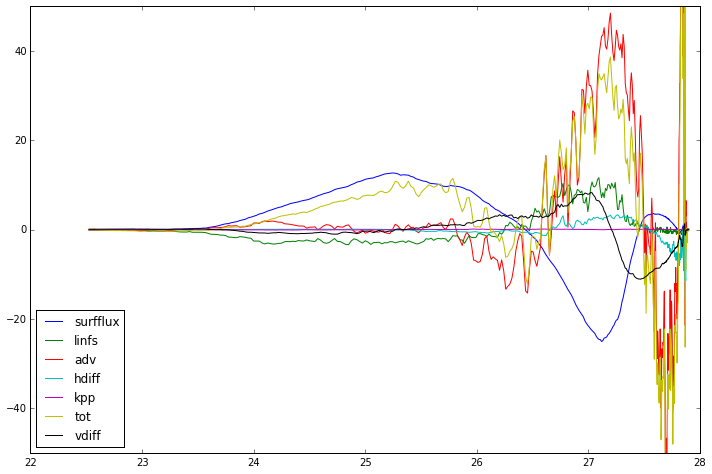

In [55]:
plt.figure(figsize=(12,8))
plt.plot(rholevs[1:]-1000., sig0_transformation_rate.mean(axis=0).T/1e6)
plt.legend(labels, loc='lower left')
plt.ylim([-50,50])
#plt.legend(rholevs, loc='lower right')


In [ ]:
sig0_transformation_rate

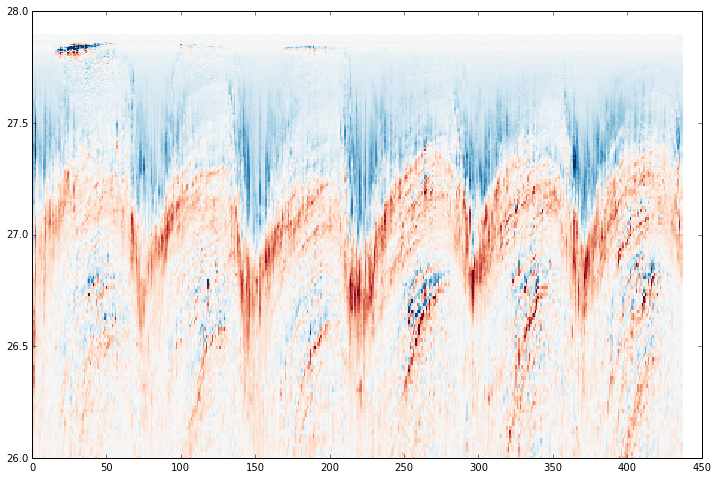

In [62]:
plt.figure(figsize=(12,8))
T = np.arange(len(iters))
plt.pcolormesh(T, rholevs[1:]-1000., sig0_transformation_rate[:,-1].T/1e6, cmap='RdBu_r')
plt.ylim([26,28])
plt.clim([-50,50])

In [7]:
res = lview.map(calc_transformation, iters)
#wmt_res.get()

In [18]:
res.progress

KeyError: u'3a93690a-f1af-46bb-90ff-c81bcdfb71ba'

In [ ]:
wmt_salt = []

for i in iters:
    print i
    salt = m.rdmds('SOstt_5d', i, rec=1)
    salt_budget = budgets.TracerBudget(m,
                    'SO_Sbdg5', 'SO_Surf5d', trname='SLT',
                    iters=i)
    wmb_salt = budgets.WaterMassBudget(m, Slevs, extra_mask=extra_mask)
    trs, labels = wmb_salt.calc_transformation_rates(salt, salt_budget)
    wmt_salt.append(trs)

/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000000480.meta
/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000000480.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000000480.meta
/home/rpa/mitgcmdata/mitgcmdata/budgets.py:222: RuntimeWarning: divide by zero encountered in reciprocal
  (self.m.drf * self.m.hFacC)**-1, 0.)


480
960

/home/rpa/mitgcmdata/mitgcmdata/budgets.py:227: RuntimeWarning: divide by zero encountered in reciprocal
  (self.m.drf * self.m.hFacC)**-1, 0.)
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000000960.meta
/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000000960.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000000960.meta



1440

/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000001440.meta
/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000001440.meta



1920

/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000001440.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000001920.meta
/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000001920.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000001920.meta



2400

/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000002400.meta
/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000002400.meta



2880

/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000002400.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000002880.meta
/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000002880.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000002880.meta



3360

/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000003360.meta
/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000003360.meta



3840

/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000003360.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000003840.meta
/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000003840.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000003840.meta



4320

/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000004320.meta
/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000004320.meta



4800

/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000004320.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000004800.meta
/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000004800.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000004800.meta


In [6]:
wmt_theta = []
for i in iters:
    print i
    theta = m.rdmds('SOstt_5d', i, rec=0)
    theta_budget = budgets.TracerBudget(m,
                    'SO_Tbdg5', 'SO_Surf5d',
                    iters=i, trname='TH',
                    swflux_name='oceQsw',
                    avg_iters=True, usememmap=True)
    Tlevs = np.linspace(-2.1,29,200)
    wmb = budgets.WaterMassBudget(m, Tlevs)
    tr, labels = wmb.calc_transformation_rates(theta, theta_budget)
    wmt_theta.append(tr)
    

/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000000480.meta
/data/scratch/rpa/SOSE/run_matt/SO_Tbdg5.0000000480.meta


480
TOTTTEND
surfflux_recidx

/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000000480.meta
/home/rpa/mitgcmdata/mitgcmdata/budgets.py:226: RuntimeWarning: divide by zero encountered in reciprocal
  (self.m.drf * self.m.hFacC)**-1, 0.)
/home/rpa/mitgcmdata/mitgcmdata/budgets.py:231: RuntimeWarning: divide by zero encountered in reciprocal
  (self.m.drf * self.m.hFacC)**-1, 0.)
/home/rpa/mitgcmdata/mitgcmdata/budgets.py:216: RuntimeWarning: divide by zero encountered in reciprocal
  (self.m.drf * self.m.hFacC)**-1, 0.)


 1
surfflux.shape (8, 320, 2160)
<class 'mitgcmdata.budgets.TracerBudget'>
960

/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000000960.meta
/data/scratch/rpa/SOSE/run_matt/SO_Tbdg5.0000000960.meta



TOTTTEND
surfflux_recidx 1
surfflux.shape (8, 320, 2160)
<class 'mitgcmdata.budgets.TracerBudget'>
1440

/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000000960.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000001440.meta



TOTTTEND

/data/scratch/rpa/SOSE/run_matt/SO_Tbdg5.0000001440.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000001440.meta



surfflux_recidx 1
surfflux.shape (8, 320, 2160)
<class 'mitgcmdata.budgets.TracerBudget'>
1920

/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000001920.meta
/data/scratch/rpa/SOSE/run_matt/SO_Tbdg5.0000001920.meta



TOTTTEND
surfflux_recidx 1
surfflux.shape (8, 320, 2160)
<class 'mitgcmdata.budgets.TracerBudget'>
2400

/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000001920.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000002400.meta



TOTTTEND

/data/scratch/rpa/SOSE/run_matt/SO_Tbdg5.0000002400.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000002400.meta



surfflux_recidx 1
surfflux.shape (8, 320, 2160)
<class 'mitgcmdata.budgets.TracerBudget'>
2880

/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000002880.meta
/data/scratch/rpa/SOSE/run_matt/SO_Tbdg5.0000002880.meta



TOTTTEND
surfflux_recidx 1
surfflux.shape (8, 320, 2160)
<class 'mitgcmdata.budgets.TracerBudget'>
3360

/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000002880.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000003360.meta



TOTTTEND

/data/scratch/rpa/SOSE/run_matt/SO_Tbdg5.0000003360.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000003360.meta



surfflux_recidx 1
surfflux.shape (8, 320, 2160)
<class 'mitgcmdata.budgets.TracerBudget'>
3840

/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000003840.meta
/data/scratch/rpa/SOSE/run_matt/SO_Tbdg5.0000003840.meta



TOTTTEND
surfflux_recidx 1
surfflux.shape (8, 320, 2160)
<class 'mitgcmdata.budgets.TracerBudget'>
4320

/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000003840.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000004320.meta



TOTTTEND

/data/scratch/rpa/SOSE/run_matt/SO_Tbdg5.0000004320.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000004320.meta



surfflux_recidx 1
surfflux.shape (8, 320, 2160)
<class 'mitgcmdata.budgets.TracerBudget'>
4800

/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000004800.meta
/data/scratch/rpa/SOSE/run_matt/SO_Tbdg5.0000004800.meta



TOTTTEND
surfflux_recidx 1
surfflux.shape (8, 320, 2160)
<class 'mitgcmdata.budgets.TracerBudget'>
5280

/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000004800.meta
/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000005280.meta



TOTTTEND

/data/scratch/rpa/SOSE/run_matt/SO_Tbdg5.0000005280.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000005280.meta



surfflux_recidx 1
surfflux.shape (8, 320, 2160)
<class 'mitgcmdata.budgets.TracerBudget'>
5760

/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000005760.meta
/data/scratch/rpa/SOSE/run_matt/SO_Tbdg5.0000005760.meta



TOTTTEND
surfflux_recidx 1
surfflux.shape (7, 320, 2160)


/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000005760.meta


ValueError: 'oceQsw' is not in list

In [39]:
a = np.array([1, 1, 0, 0, 0,], 'bool')
b = np.array([0, 1, 1, 0, 0,], 'bool')
a += b
print a


[ True  True  True False False]


In [44]:
salt = m.rdmds('SOstt_5d', rec=1)
salt_budget = budgets.TracerBudget(m,
                'SO_Sbdg5', 'SO_Surf5d', trname='SLT',
                iters=480, avg_iters=True, usememmap=True)

/data/scratch/rpa/SOSE/run_matt/SOstt_5d.0000035040.meta
/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000000480.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000000480.meta


<matplotlib.colorbar.Colorbar instance at 0x7fa9ad46c518>

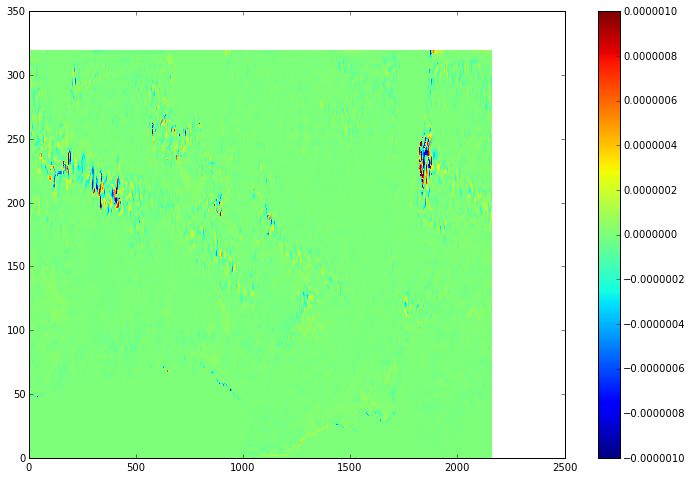

In [31]:
extra_mask = np.zeros(m.shape)
extra_mask[:,-1] = 1

sb2d, sb3d = salt_budget.flux_convergence()
plt.figure(figsize=(12,8))
plt.pcolormesh(np.ma.masked_array(sb3d['tot'], extra_mask)[5])
plt.clim([-1e-6,1e-6])
plt.colorbar()

<class 'mitgcmdata.budgets.TracerBudget'>


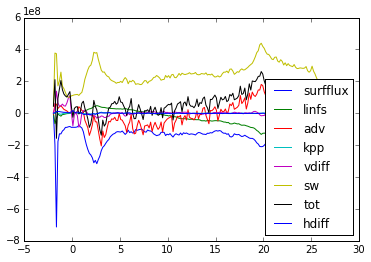

In [10]:
reload(budgets)
Tlevs = np.linspace(-2.1,29,200)
wmb = budgets.WaterMassBudget(m, Tlevs)
tr, labels = wmb.calc_transformation_rates(theta, theta_budget)

plt.plot(Tlevs[1:], tr.T)
plt.legend(labels, loc='lower right')


In [72]:
salt * None

TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

In [11]:
Slevs = np.linspace(32,38,200)
wmb_salt = budgets.WaterMassBudget(m, Slevs)
trs, labels = wmb_salt.calc_transformation_rates(salt, salt_budget)

<class 'mitgcmdata.budgets.TracerBudget'>


(438, 7, 199)


(-100, 100)

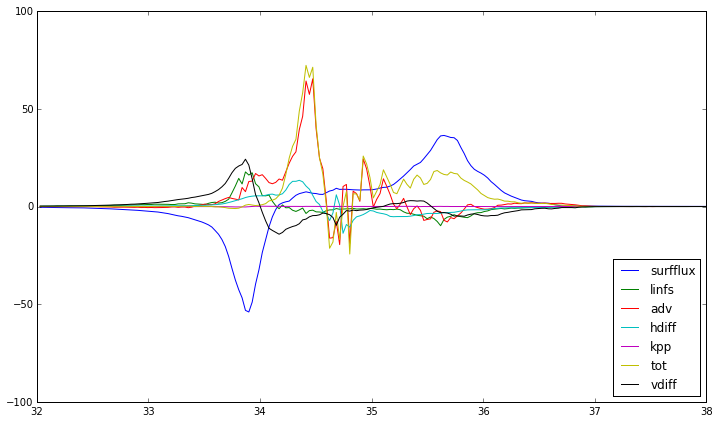

In [24]:
wmt_tot = np.array(np.array(res))
print wmt_tot.shape


plt.figure(figsize=(12,7))
plt.plot(Slevs[1:], wmt_tot.mean(axis=0).T/1e6)
plt.legend(labels, loc='lower right')
plt.ylim([-100,100])

In [6]:
reload(budgets)

# both THETA and SALT budgets
tracer_budgets = {
     'T': budgets.TracerBudget(m,
                'SO_Tbdg5', 'SO_Surf5d', trname='TH',
                swflux_name='oceQsw',
                iters=iters, avg_iters=True, usememmap=True),
     'S': budgets.TracerBudget(m,
                'SO_Sbdg5', 'SO_Surf5d', trname='SLT',
                iters=iters, avg_iters=True, usememmap=True)
}

ERROR! Session/line number was not unique in database. History logging moved to new session 61
TOTTTEND

/data/scratch/rpa/SOSE/run_matt/SO_Tbdg5.0000000480.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000000480.meta



surfflux_recidx 1
surfflux.shape (8, 320, 2160)
TOTSTEND

/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000000480.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000000480.meta



surfflux_recidx 2
surfflux.shape (8, 320, 2160)


In [4]:
#%load_ext line_profiler
b = tracer_budgets['T']
%lprun -f b.flux_convergence b.flux_convergence()

ERROR: Line magic function `%lprun` not found.


/home/rpa/mitgcmdata/mitgcmdata/budgets.py:226: RuntimeWarning: divide by zero encountered in reciprocal
  return -self.m.rk_sign * (self.surfflux * recip_drf[0])
/home/rpa/mitgcmdata/mitgcmdata/budgets.py:231: RuntimeWarning: divide by zero encountered in reciprocal
  return -self.m.rk_sign * (self.surf_wmass * recip_drf[0])
/home/rpa/mitgcmdata/mitgcmdata/budgets.py:216: RuntimeWarning: divide by zero encountered in reciprocal
  swfull = -self.m.rk_sign * (


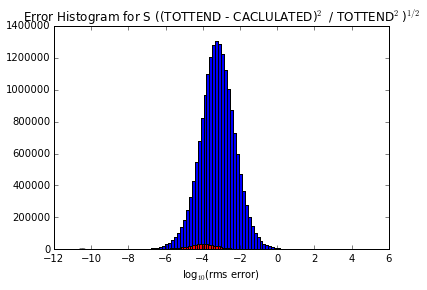

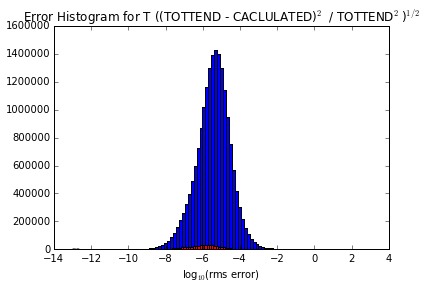

In [7]:
for trname, b in tracer_budgets.iteritems():
    
    #tot_vflux, adv_vflux, diff_vflux = b.net_vertical_flux()
    #tot_mflux, adv_mflux, diff_mflux = b.net_meridional_flux()
    #tot_flux_conv, adv_flux_conv, diff_flux_conv, surf_flux_conv, sw_flux_conv = b.flux_convergence()
    #surf_wmass_conv = b.flux_convergence_surf_wmass()
    c2d, c3d = b.flux_convergence()
    
    tot_flux_conv = c3d['tot']
    err = np.ma.masked_invalid(
            np.sqrt((b.tottend - tot_flux_conv)**2 /
             b.tottend**2 ))[...,:300,:]
    log_err = np.ma.masked_invalid(np.log10(err))

    r = 2*np.median(m.mask_field(c3d['adv']**2)[0].compressed()**0.5)
    if trname=='T':
        r *= 3
    
    #true_surf_flux = surf_flux_conv.copy()
    #if sw_flux_conv is not None:
    #    true_surf_flux += sw_flux_conv[0]
    
    if False:
        plt.figure(figsize=(16,18))

        Nitems = 7
        Nplots = Nitems + 1

        for n, k in enumerate(['surfflux', 'linfs']):
            plt.subplot(Nplots, 1, n+1, axisbg='k')
            plt.pcolormesh(np.ma.masked_array(c2d[k], m.mask[0]), cmap='RdBu_r')
            plt.title('%s - %s' % (k, trname))
            plt.xlim([0,m.Nx])
            plt.ylim([0,300])
            plt.clim([-r,r])
            plt.colorbar()

        for n, k in enumerate(['adv', 'diff', 'kpp', 'sw', 'tot']):
            if c3d.has_key(k):
                plt.subplot(Nplots, 1, n+3, axisbg='k')
                plt.pcolormesh(m.mask_field(c3d[k])[0], cmap='RdBu_r')
                plt.title('%s - %s' % (k, trname))
                plt.xlim([0,m.Nx])
                plt.ylim([0,300])
                plt.clim([-r,r])
                plt.colorbar()


        plt.subplot(Nplots, 1, Nplots, axisbg='k')
        plt.pcolormesh(m.mask_field(b.tottend)[0], cmap='RdBu_r')
        plt.title('Model TOTTEND - %s' % trname)
        plt.xlim([0,m.Nx])
        plt.ylim([0,300])
        plt.clim([-r,r])
        plt.colorbar()

    plt.figure()
    plt.hist(log_err.compressed().ravel(), bins=100);
    plt.hist(log_err[0].compressed().ravel(), bins=100, color='r');
    plt.xlabel(r'log$_{10}$(rms error)')
    plt.title(r'Error Histogram for %s ((TOTTEND - CACLULATED)$^2$ / TOTTEND$^2$)$^{1/2}$' % trname)
    

In [11]:
c2d.values()

[array([[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
        [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
        [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
        ..., 
        [ -2.24224827e-06,  -2.22750584e-06,  -2.21199675e-06, ...,
          -2.24772864e-06,  -2.24717385e-06,  -2.24977912e-06],
        [ -2.38440510e-06,  -2.36639999e-06,  -2.34839009e-06, ...,
          -2.39434559e-06,  -2.39801505e-06,  -2.39678919e-06],
        [ -2.49401225e-06,  -2.48561248e-06,  -2.47725220e-06, ...,
          -2.48398021e-06,  -2.49247965e-06,  -2.49751154e-06]]),
 array([[ -0.00000000e+00,  -0.00000000e+00,  -0.00000000e+00, ...,
          -0.00000000e+00,  -0.00000000e+00,  -0.00000000e+00],
        [ -0.00000000e+00,  -0.00000000e+00,  -0.00000000e+0

In [42]:
layers_sw = m.rdmds('layers_sw.01',480)

/glade/scratch/rpa/SOSE/run_matt_layers/layers_sw.01.0000000480.meta


<matplotlib.colorbar.Colorbar instance at 0x2b710d3a6518>

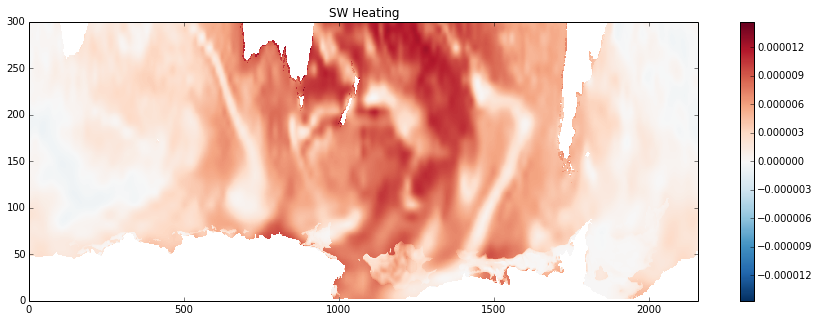

In [69]:
n = 0
plt.figure(figsize=(15,5))
plt.pcolormesh(m.mask_field(layers_sw)[n], cmap='RdBu_r')
plt.title('SW Heating')
plt.xlim([0,m.Nx])
plt.ylim([0,300])
plt.clim([-2*r,2*r])
plt.colorbar()

In [8]:
EXFswnet = m.rdmds('SO_Surf5d', 480, rec=5)
oceQsw = m.rdmds('SO_Surf5d', 480, rec=7)

/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000000480.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000000480.meta


128784485.754
-135127575.586


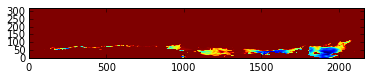

In [11]:
print oceQsw.sum()
print EXFswnet.sum()
plt.figure()
plt.imshow(oceQsw+EXFswnet, origin='bottom');


<matplotlib.colorbar.Colorbar instance at 0x2b710d0781b8>

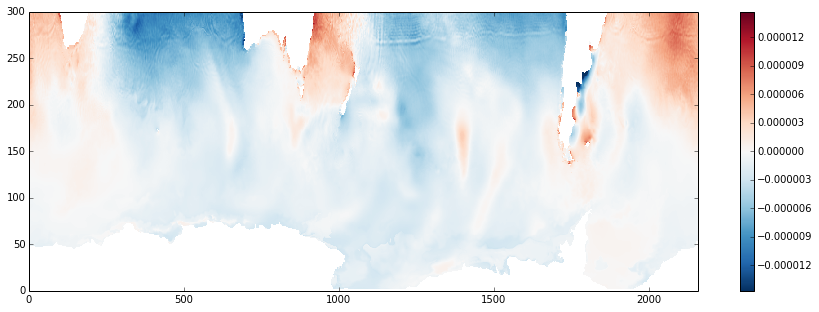

In [81]:
plt.figure(figsize=(15,5))
plt.pcolormesh(np.ma.masked_array(layers_surf[0], m.mask[0]), cmap='RdBu_r')
plt.xlim([0,m.Nx])
plt.ylim([0,300])
plt.clim([-2*r,2*r])
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x2b710c739098>

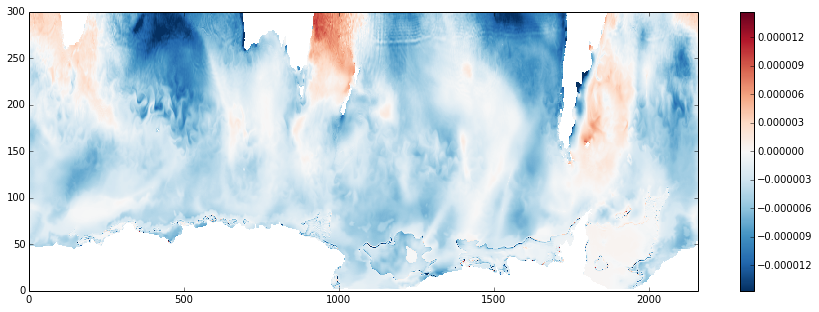

In [83]:
plt.figure(figsize=(15,5))
plt.pcolormesh(np.ma.masked_array(surf_flux_conv, m.mask[0]), cmap='RdBu_r')
plt.xlim([0,m.Nx])
plt.ylim([0,300])
plt.clim([-2*r,2*r])
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x2b7119b95dd0>

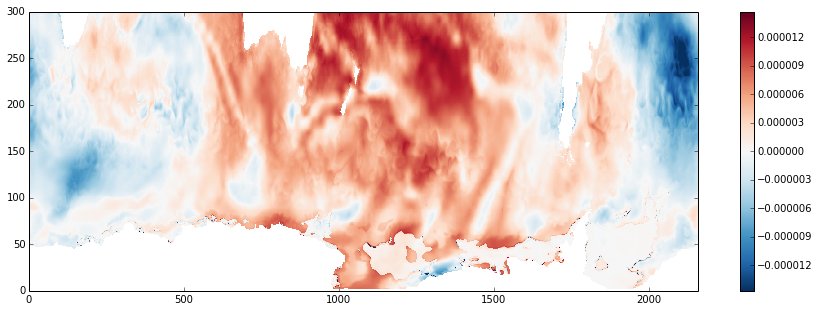

In [86]:
plt.figure(figsize=(15,5))
plt.pcolormesh(np.ma.masked_array(surf_flux_conv-layers_surf[0], m.mask[0]), cmap='RdBu_r')
plt.xlim([0,m.Nx])
plt.ylim([0,300])
plt.clim([-2*r,2*r])
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x2b7119d30cf8>

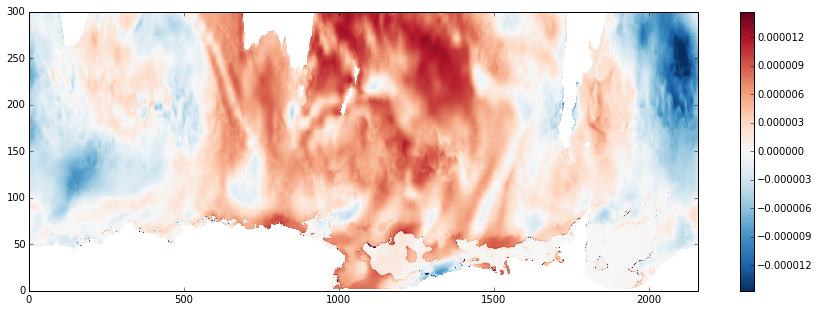

In [91]:
plt.figure(figsize=(15,5))
plt.pcolormesh(np.ma.masked_array(b.surfflux - b.surf_wmass, m.mask[0])/m.drf[0], cmap='RdBu_r')
plt.xlim([0,m.Nx])
plt.ylim([0,300])
plt.clim([-2*r,2*r])
plt.colorbar()

## layers_surfflux only has the wvelmass component! missing all other fluxes!! ##

In [107]:
# lets look at salinity

b = tracer_budgets['S']
tot_flux_conv, adv_flux_conv, diff_flux_conv, surf_flux_conv, sw_flux_conv = b.flux_convergence()

<matplotlib.colorbar.Colorbar instance at 0x2b717b2bbb90>

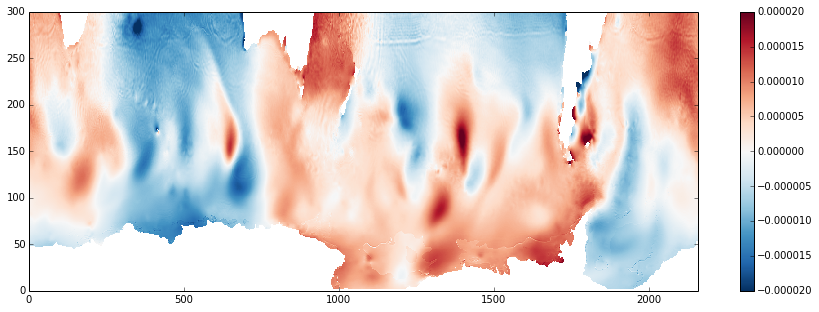

In [110]:
r = 2e-5
plt.figure(figsize=(15,5))
plt.pcolormesh(np.ma.masked_array(surf_flux_conv, m.mask[0]), cmap='RdBu_r')
plt.xlim([0,m.Nx])
plt.ylim([0,300])
plt.clim([-r,r])
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x2b717b3fbd40>

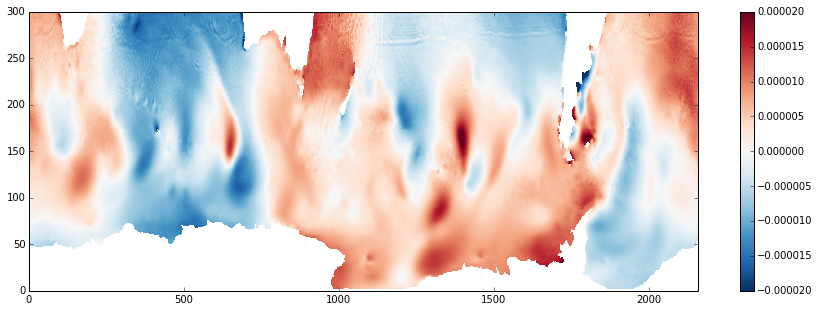

In [111]:
plt.figure(figsize=(15,5))
plt.pcolormesh(np.ma.masked_array(layers_surf[1], m.mask[0]), cmap='RdBu_r')
plt.xlim([0,m.Nx])
plt.ylim([0,300])
plt.clim([-r,r])
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x2b717ba600e0>

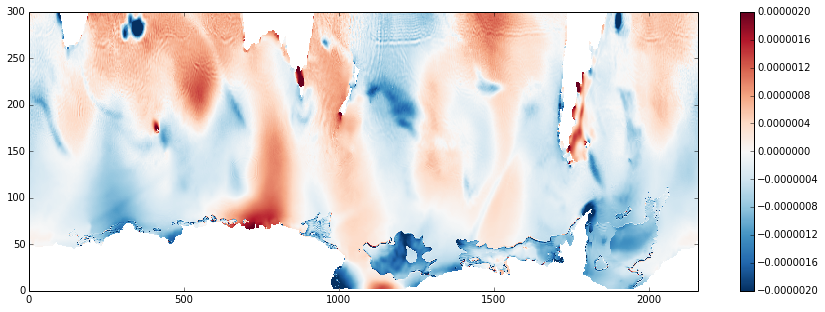

In [117]:
r=2e-6
plt.figure(figsize=(15,5))
plt.pcolormesh(np.ma.masked_array(surf_flux_conv-layers_surf[1], m.mask[0]), cmap='RdBu_r')
plt.xlim([0,m.Nx])
plt.ylim([0,300])
plt.clim([-r,r])
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x2b717bba2950>

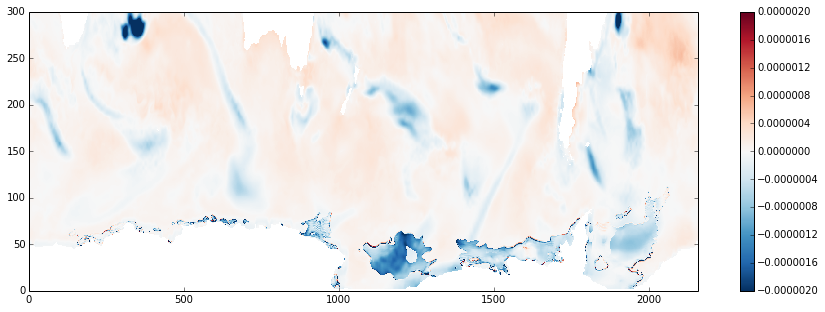

In [118]:
plt.figure(figsize=(15,5))
plt.pcolormesh(np.ma.masked_array(b.surfflux - b.surf_wmass, m.mask[0])/m.drf[0], cmap='RdBu_r')
plt.xlim([0,m.Nx])
plt.ylim([0,300])
plt.clim([-r,r])
plt.colorbar()

## There is still a mismatch in salinity. But it is not the same as for theta. ##

In [17]:
tot_flux_conv.shape

(42, 320, 2160)

In [24]:
len({'a': 3})

1

In [10]:
from MITgcmutils import jmd95

In [12]:
jmd95.densjmd95?